In [1]:
%pip install --user torch transformers scikit-learn matplotlib seaborn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import io
import requests
import numpy as np
import torch
import time
import urllib3
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D

# Suppress SSL warnings for legacy government sites
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Global Constants
START_YEAR = 2005
END_YEAR = 2024

# ==========================================
# Configuration: Target State Portals
# ==========================================
TARGET_PORTALS = {
    'AL': 'data-algeohub.opendata.arcgis.com', 'FL': 'geodata.floridagio.gov', 'GA': 'data-hub.gio.georgia.gov',
    'KY': 'opengisdata.ky.gov', 'LA': 'data-ladotd.opendata.arcgis.com', 'MS': 'opendata.gis.ms.gov',
    'ND': 'gishubdata-ndgov.hub.arcgis.com', 'NH': 'new-hampshire-geodata-portal-1-nhgranit.hub.arcgis.com',
    'SD': 'opendata2017-09-18t192802468z-sdbit.opendata.arcgis.com', 'WI': 'data-wi-dnr.opendata.arcgis.com',
    'WY': 'data.geospatialhub.org', 'AR': 'data.arkansas.gov', 'AZ': 'data.az.gov', 'CT': 'data.ct.gov',
    'DE': 'data.delaware.gov', 'IA': 'data.iowa.gov', 'ID': 'data.idaho.gov', 'IL': 'data.illinois.gov',
    'IN': 'hub.mph.in.gov', 'KS': 'data.kansas.gov', 'MD': 'data.maryland.gov', 'ME': 'data.maine.gov',
    'MI': 'data.michigan.gov', 'MO': 'data.mo.gov', 'NE': 'data.nebraska.gov', 'NJ': 'data.nj.gov',
    'NV': 'data.nv.gov', 'OR': 'data.oregon.gov', 'PA': 'data.pa.gov', 'TX': 'data.texas.gov',
    'VT': 'data.vermont.gov', 'WA': 'data.wa.gov', 'CA': 'data.ca.gov', 'HI': 'opendata.hawaii.gov',
    'MN': 'gisdata.mn.gov', 'OK': 'data.ok.gov', 'VA': 'data.virginia.gov'
}

US_STATES_MAP = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC'
}

In [2]:
# Metadata Acquisition
def fetch_metadata_hybrid(limit=100):
    """
    Fetches dataset metadata from target state portals using a hybrid strategy.
    This function attempts to retrieve metadata (description and creation date)
    by trying three different API endpoints in order: ArcGIS (DCAT), Socrata, and CKAN.
    
    Args:
        limit (int): The maximum number of datasets to fetch per portal. Defaults to 100.
    Returns:
        pd.DataFrame: A DataFrame containing columns ['state', 'description', 'created_at', 'year'].
                      Returns only datasets created between 2000 and 2025.
    """
    all_data = []
    
    for abbr, domain in TARGET_PORTALS.items():
        found = False
        datasets = []
        base_url = f"https://{domain}"

        # Strategy 1: ArcGIS
        try:
            r = requests.get(f"{base_url}/api/feed/dcat-us/1.1.json", timeout=5, verify=False)
            if r.status_code == 200:
                items = r.json().get('dataset', [])
                for item in items[:limit]:
                    datasets.append({"state": abbr, "description": item.get("description", ""), "created_at": item.get("issued") or item.get("modified")})
                if items: found = True
        except: pass

        # Strategy 2: Socrata
        if not found:
            try:
                r = requests.get(f"https://{domain}/api/views", params={"limit": limit}, timeout=3, verify=False)
                if r.status_code == 200:
                    items = r.json()
                    if isinstance(items, list):
                        for item in items:
                            datasets.append({"state": abbr, "description": item.get("description", ""), "created_at": item.get("createdAt")})
                        if items: found = True
            except: pass

        # Strategy 3: CKAN
        if not found:
            try:
                r = requests.get(f"{base_url}/api/3/action/package_search", params={"rows": limit}, timeout=5, verify=False)
                if r.status_code == 200 and r.json().get('success'):
                    items = r.json().get('result', {}).get('results', [])
                    for item in items:
                        datasets.append({"state": abbr, "description": item.get("notes", ""), "created_at": item.get("metadata_created") or item.get("created")})
                    if items: found = True
            except: pass

        if datasets: all_data.extend(datasets)

    df = pd.DataFrame(all_data)
    
    def safe_extract_year(val):
        """Helper to safely extract year from various date formats."""
        try:
            if pd.isnull(val): return np.nan
            if isinstance(val, (int, float)): return pd.to_datetime(val, unit='ms' if val > 10000000000 else 's').year
            return pd.to_datetime(str(val), errors='coerce').year
        except: return np.nan

    if not df.empty:
        df["year"] = df["created_at"].apply(safe_extract_year)
        df = df[(df['year'] >= 2000) & (df['year'] <= 2025)]
        
    print(f"Total valid datasets: {len(df)} from {df['state'].nunique()} states.")
    return df

In [3]:
# GDP Data Loading
def load_local_gdp_file(file_path='SAGDP1__ALL_AREAS_1997_2024.csv'):
    """
    Loads and cleans GDP data from the Bureau of Economic Analysis (BEA) CSV file.
    It handles header skipping, state abbreviation mapping, and reshaping the data
    from wide format (years as columns) to long format.
    Args:
        file_path (str): Path to the local BEA GDP CSV file.
    Returns:
        pd.DataFrame: DataFrame with columns ['state_abbr', 'year', 'gdp'].
                      Returns an empty DataFrame if the file is not found or invalid.
    """
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f: content = f.read()
    except FileNotFoundError: return pd.DataFrame()

    lines = content.splitlines()
    header_idx = 0 
    
    df = pd.read_csv(io.StringIO("\n".join(lines[header_idx:])), dtype=str)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df = df.map(lambda x: x.strip().replace('"', '') if isinstance(x, str) else x)

    if 'LineCode' in df.columns: df = df[df['LineCode'] == '1']
    if 'GeoName' in df.columns:
        df['state_abbr'] = df['GeoName'].map(US_STATES_MAP)
        df = df.dropna(subset=['state_abbr'])

        year_cols = [c for c in df.columns if c.isdigit() and START_YEAR <= int(c) <= END_YEAR]
        df_melt = df.melt(id_vars=['state_abbr'], value_vars=year_cols, var_name='year', value_name='gdp')
        df_melt['year'] = pd.to_numeric(df_melt['year'], errors='coerce').astype(int)
        df_melt['gdp'] = pd.to_numeric(df_melt['gdp'], errors='coerce')
        
        print(f"  Loaded GDP Data: {len(df_melt)} rows")
        return df_melt[['state_abbr', 'year', 'gdp']]
    else:
        return pd.DataFrame()

In [4]:
# Population Data Acquisition
def fetch_census_population(api_key):
    """
    Fetches annual state population data from the US Census Bureau API.
    It retrieves data for years between START_YEAR and END_YEAR. Missing data points
    are handled via linear interpolation to ensure a complete time series.

    Args:
        api_key (str): A valid US Census Bureau API Key.

    Returns:
        pd.DataFrame: DataFrame with columns ['state_abbr', 'year', 'population'].
    """
    all_pop = []
    years = range(START_YEAR, END_YEAR + 1)
    
    for year in years:
        try:
            r = requests.get(f"https://api.census.gov/data/{year}/acs/acs1", params={"get": "B01003_001E,NAME", "for": "state:*", "key": api_key}, timeout=3)
            if r.status_code == 200:
                data = r.json()
                df_year = pd.DataFrame(data[1:], columns=data[0])
                df_year['year'] = year
                all_pop.append(df_year)
        except: pass
    
    if not all_pop: return pd.DataFrame()
    
    df_pop = pd.concat(all_pop, ignore_index=True)
    df_pop['population'] = pd.to_numeric(df_pop['B01003_001E'], errors='coerce')
    df_pop['state_abbr'] = df_pop['NAME'].map(US_STATES_MAP)
    df_pop = df_pop.dropna(subset=['state_abbr'])

    # Ensure continuity via interpolation
    all_states = df_pop['state_abbr'].unique()
    full_index = pd.MultiIndex.from_product([all_states, years], names=['state_abbr', 'year'])
    df_full = df_pop.set_index(['state_abbr', 'year']).reindex(full_index).reset_index()

    df_full['population'] = df_full.groupby('state_abbr')['population'].transform(lambda x: x.interpolate())
    return df_full[['state_abbr', 'year', 'population']]

In [5]:
# BFS Data Loading
def load_local_bfs_file(file_path='BFS-mf.csv'):
    """
    Parses the US Census Business Formation Statistics (BFS) CSV file using fixed section indices.
    The BFS CSV is structured with multiple disconnected sections (Data, Geo, Date, Period).
    This function reads specific line ranges, merges the sections, filters for 'High-Propensity
    Business Applications' (HBA_BA), and aggregates to the state level.
    Args:
        file_path (str): Path to the BFS CSV file.

    Returns:
        pd.DataFrame: Pivot table with columns ['state_abbr', 'year', 'HBA_BA'].
    """
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f: content = f.read()
    except FileNotFoundError: return pd.DataFrame()
    
    lines = content.splitlines()
    def read_section(start_idx):
        section_lines = [lines[start_idx]]
        for i in range(start_idx + 1, len(lines)):
            if lines[i].strip() == "": break
            section_lines.append(lines[i])
        return pd.read_csv(io.StringIO("\n".join(section_lines)), dtype=str)

    # Fixed indices for specific sections in the CSV structure
    df_data = read_section(381)
    df_geo  = read_section(43)
    df_dt   = read_section(27)
    df_per  = read_section(104)

    # Convert indices to numeric for merging
    for col in ['per_idx', 'geo_idx', 'dt_idx']: df_data[col] = pd.to_numeric(df_data[col], errors='coerce')
    df_per['per_idx'] = pd.to_numeric(df_per['per_idx'], errors='coerce')
    df_geo['geo_idx'] = pd.to_numeric(df_geo['geo_idx'], errors='coerce')
    df_dt['dt_idx']   = pd.to_numeric(df_dt['dt_idx'], errors='coerce')

    def parse_year(s):
        """Parses year from BFS format (e.g., '2005' or '05')."""
        try:
            parts = str(s).split('-')
            y = int(parts[1])
            # If 2 digits, assume 2000s; if 4 digits, keep as is.
            if y < 100:
                return 2000 + y
            else:
                return y
        except:
            return np.nan

    df_per['year'] = df_per['per_name'].apply(parse_year)
    df_per = df_per.dropna(subset=['year'])
    df_per['year'] = df_per['year'].astype(int)

    # Merge all sections
    df_merged = df_data.merge(df_per[['per_idx', 'year']], on='per_idx', how='inner')
    df_merged = df_merged.merge(df_geo[['geo_idx', 'geo_code']], on='geo_idx', how='inner')
    df_merged = df_merged.merge(df_dt[['dt_idx', 'dt_code']], on='dt_idx', how='inner')

    if 'dt_code' in df_merged.columns: df_merged['dt_code'] = df_merged['dt_code'].astype(str).str.strip()
    if 'geo_code' in df_merged.columns: df_merged['geo_code'] = df_merged['geo_code'].astype(str).str.strip()

    # Filtering logic
    df_merged = df_merged[df_merged['year'] >= START_YEAR]
    if 'is_adj' in df_merged.columns:
        df_merged['is_adj'] = pd.to_numeric(df_merged['is_adj'], errors='coerce')
        df_merged = df_merged[df_merged['is_adj'] == 0]

    # Keep only High-Propensity Business Applications (BA_HBA)
    df_merged = df_merged[df_merged['dt_code'].isin(['BA_BA', 'BA_HBA'])]
    if 'val' in df_merged.columns:
        df_merged['val'] = pd.to_numeric(df_merged['val'].astype(str).str.replace(',', ''), errors='coerce')

    # Pivot to make it one row per state-year
    df_pivot = df_merged.pivot_table(index=['geo_code', 'year'], columns='dt_code', values='val', aggfunc='sum').reset_index()
    df_pivot = df_pivot.rename(columns={'geo_code': 'state_abbr', 'BA_HBA': 'HBA_BA'})
    print(f"Loaded BFS Data: {len(df_pivot)} rows")
    return df_pivot

In [6]:
# NLP & Semantic Analysis
class SemanticAnalyzer:
    """
    A class to handle semantic embedding and scoring using Hugging Face Transformers.
    """

    def __init__(self, model_name="gpt2"):
        """
        Initializes the model and tokenizer.
        
        Args:
            model_name (str): The name of the pre-trained model to use (default: 'gpt2').
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Use GPU if available, else CPU
        self.model = AutoModel.from_pretrained(model_name).to('cuda' if torch.cuda.is_available() else 'cpu')
        if self.tokenizer.pad_token is None: self.tokenizer.pad_token = self.tokenizer.eos_token

    def embed(self, text):
        """
        Generates an embedding vector for the input text using mean pooling.

        Args:
            text (str): Input text to embed.

        Returns:
            np.array: A 1D numpy array representing the semantic embedding.
        """
        if not text: return np.zeros(self.model.config.hidden_size)
        tokens = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True).to(self.model.device)
        with torch.no_grad(): out = self.model(**tokens)
        return out.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    def score(self, df, target_text):
        """
        Calculates the cosine similarity between dataset descriptions and a target text.

        Args:
            df (pd.DataFrame): DataFrame containing a 'description' column.
            target_text (str): The reference text to compare against (e.g., business keywords).

        Returns:
            pd.DataFrame: The input DataFrame with a new 'semantic_score' column.
        """
        target_vec = self.embed(target_text).reshape(1, -1)
        scores = []
        print(f"  Scoring {len(df)} datasets...")
        for i, desc in enumerate(df["description"]):
            scores.append(cosine_similarity(self.embed(desc).reshape(1, -1), target_vec)[0][0])
            if i % 1000 == 0 and i > 0: print(f"    Processed {i}")
        df["semantic_score"] = scores
        return df

def run_regression(df):
    """
    Performs OLS regression analysis on the final panel dataset.
    
    Model Formula: ln_HBA ~ avg_quality_score + ln_GDP + ln_Pop + C(state) + C(year)

    Args:
        df (pd.DataFrame): The final merged DataFrame containing all variables.
    """
    print("\n===  Regression Analysis ===")
    df = df.copy()
    # Log transformation for elasticity interpretation
    df["ln_HBA"] = np.log(df["HBA_BA"] + 1)
    df["ln_GDP"] = np.log(df["gdp"] + 1)
    df["ln_Pop"] = np.log(df["population"] + 1)
    
    df_clean = df.dropna(subset=["ln_HBA", "avg_quality_score", "ln_GDP", "ln_Pop"])
    print(f"Regressing on {len(df_clean)} observations")

    formula = "ln_HBA ~ avg_quality_score + ln_GDP + ln_Pop + C(state) + C(year)"
    try:
        model = smf.ols(formula, data=df_clean).fit()
        print(model.summary())
    except Exception as e:
        print(f"Regression failed: {e}")

In [7]:
# Main Execution Pipeline
if __name__ == "__main__":
    CENSUS_KEY = "bcdbdffc30535ef4f01e36911b44e69562920953"
    TARGET_CONTEXT = "Business finance, small business loans, startup grants, commercial zoning, economic indicators, corporate registration."

    # 1. Fetch Metadata
    df_meta = fetch_metadata_hybrid(limit=100)

    if not df_meta.empty:
        # 2. NLP Analysis
        analyzer = SemanticAnalyzer("gpt2")
        df_meta = analyzer.score(df_meta, TARGET_CONTEXT)
        
        # --- Calculate Stock (Cumulative) Scores ---
        print("\n  Calculating Annual Scores")
        panel_data = []
        analysis_years = range(START_YEAR, END_YEAR + 1)
        
        for state in df_meta['state'].unique():
            df_state = df_meta[df_meta['state'] == state]
            for year in analysis_years:
                # Stock: All datasets created up to and including the current year
                df_stock = df_state[df_state['year'] <= year]
                avg = df_stock['semantic_score'].mean() if len(df_stock) > 0 else 0
                panel_data.append({'state': state, 'year': year, 'avg_quality_score': avg})
        
        df_open = pd.DataFrame(panel_data)
        print(f"  Created Panel Data: {len(df_open)} rows")

        # 3. Load External Data
        df_bfs = load_local_bfs_file('BFS-mf.csv')
        df_gdp = load_local_gdp_file('SAGDP1__ALL_AREAS_1997_2024.csv')
        df_pop = fetch_census_population(CENSUS_KEY)

        # 4. Merge Data (with Type Conversion)
        if not df_bfs.empty and not df_gdp.empty and not df_pop.empty:
            
            # Force type conversion to int for merging keys
            df_open['year'] = df_open['year'].astype(int)
            df_bfs['year'] = df_bfs['year'].astype(int)
            df_gdp['year'] = df_gdp['year'].astype(int)
            df_pop['year'] = df_pop['year'].astype(int)

            # Strip whitespace from state codes
            df_open['state'] = df_open['state'].astype(str).str.strip()
            df_bfs['state_abbr'] = df_bfs['state_abbr'].astype(str).str.strip()
            df_gdp['state_abbr'] = df_gdp['state_abbr'].astype(str).str.strip()
            df_pop['state_abbr'] = df_pop['state_abbr'].astype(str).str.strip()

            # Merge all datasets
            df_final = df_open.merge(df_bfs, left_on=["state","year"], right_on=["state_abbr","year"], how="inner")
            df_final = df_final.merge(df_gdp, left_on=["state","year"], right_on=["state_abbr","year"], how="inner")
            df_final = df_final.merge(df_pop, left_on=["state","year"], right_on=["state_abbr","year"], how="inner")
            
            print(f"\nFinal Merged Dataset: {len(df_final)} rows")
            if len(df_final) > 0:
                print(f"States included: {sorted(df_final['state'].unique())}")
            
            if len(df_final) > 30:
                run_regression(df_final)
            else:
                print("Data insufficient.")
                

Total valid datasets: 2567 from 29 states.
  Scoring 2567 datasets...
    Processed 1000
    Processed 2000

  Calculating Annual Scores
  Created Panel Data: 580 rows
Loaded BFS Data: 1197 rows
  Loaded GDP Data: 1020 rows

Final Merged Dataset: 580 rows
States included: ['AL', 'CA', 'CT', 'DE', 'GA', 'HI', 'IA', 'IL', 'IN', 'KY', 'LA', 'MD', 'MI', 'MN', 'MO', 'MS', 'ND', 'NH', 'NJ', 'OK', 'OR', 'PA', 'SD', 'TX', 'VA', 'VT', 'WA', 'WI', 'WY']

===  Regression Analysis ===
Regressing on 580 observations
                            OLS Regression Results                            
Dep. Variable:                 ln_HBA   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1187.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:43:16   Log-Likelihood:                 510.00
No. Observations:

Scatter plot saved as 'quality_vs_business.png'


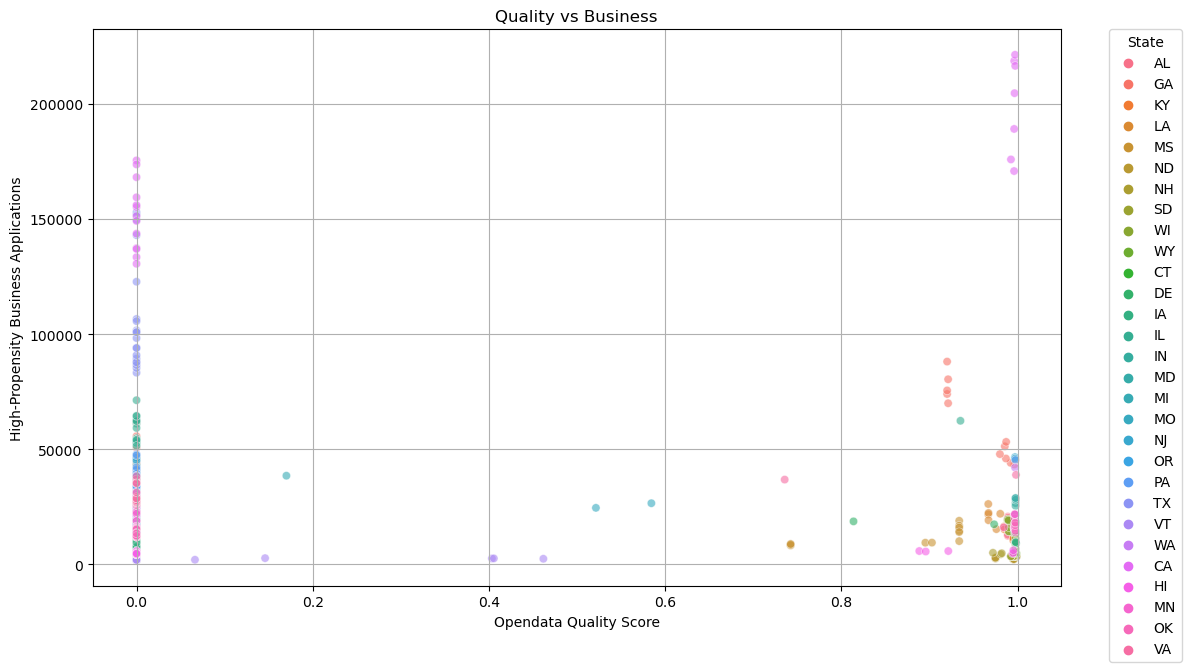

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Graph saved as 'year_vs_business.png'


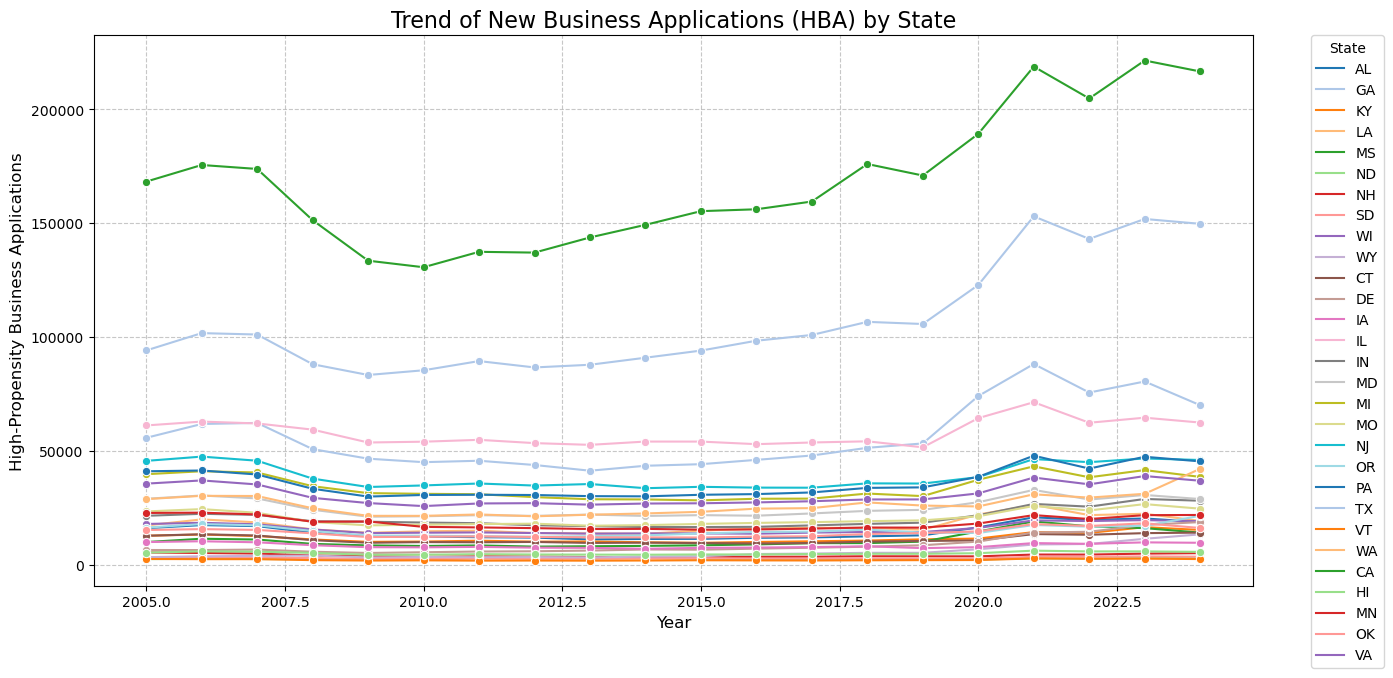

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Graph saved as 'year_vs_score.png'


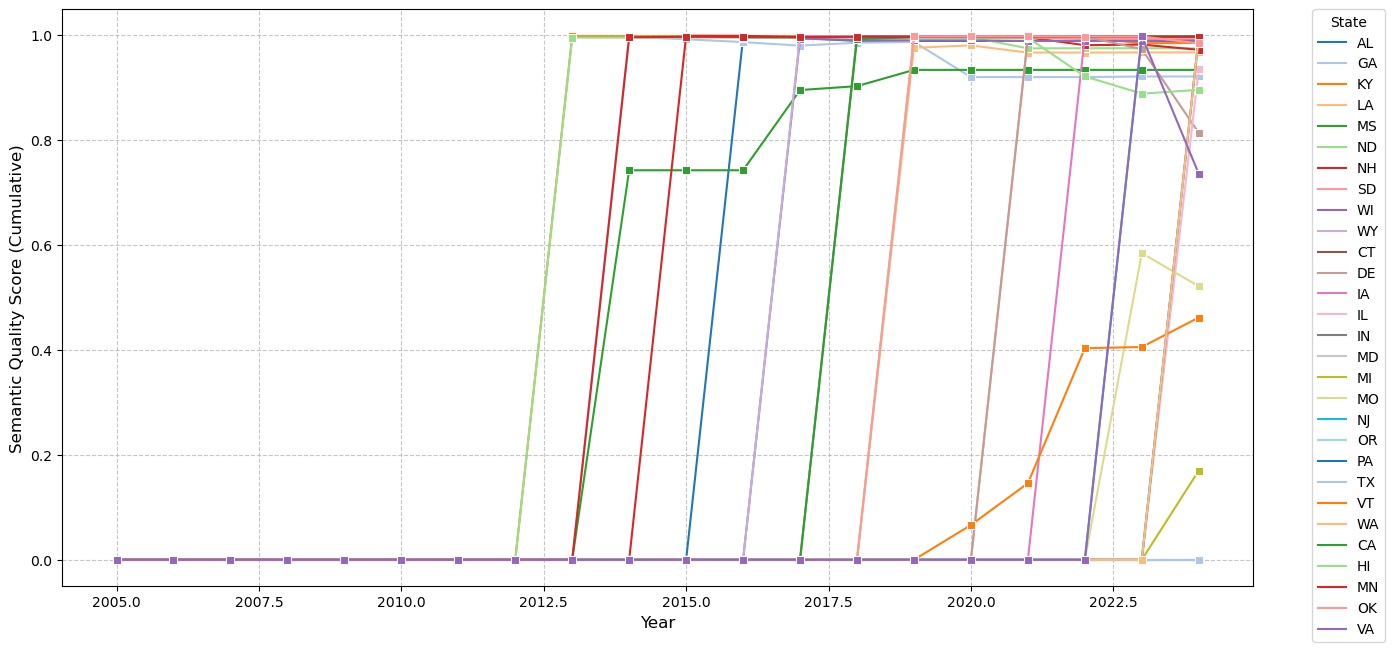

Graph saved as '3d_analysis_result.png'


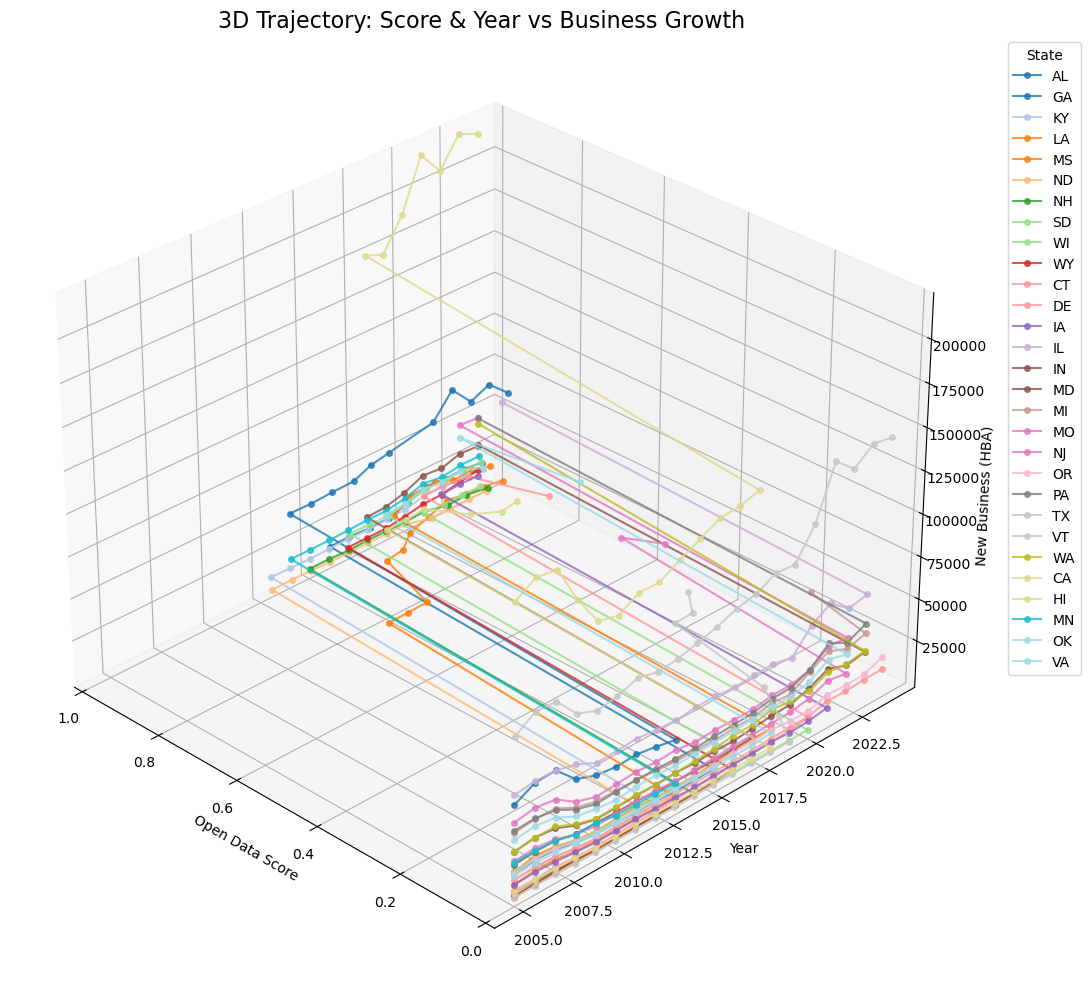

In [9]:
# Visualization 
# --- Plot 1: Scatter (Quality vs Business) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_final, 
                x="avg_quality_score", 
                y="HBA_BA", 
                hue="state", 
                legend=True,
                alpha=0.6
                )
plt.title("Quality vs Business")
plt.xlabel("Opendata Quality Score")
plt.ylabel("High-Propensity Business Applications")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='State', borderaxespad=0)
plt.tight_layout()
plt.savefig('quality_vs_business.png', dpi=300, bbox_inches='tight')
print("Scatter plot saved as 'quality_vs_business.png'")
plt.show()

# --- Plot 2: Line (Year vs Business) ---
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_final,
             x='year',
             y='HBA_BA',
             hue='state',
             marker='o',
             linewidth=1.5,
             palette="tab20"
            )
plt.title('Trend of New Business Applications (HBA) by State', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('High-Propensity Business Applications', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='State')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('year_vs_business.png', dpi=300, bbox_inches='tight')
print("Graph saved as 'year_vs_business.png'")
plt.show()

# --- Plot 3: Line (Year vs Quality Score) ---
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_final, 
             x='year', 
             y='avg_quality_score', 
             hue='state', 
             marker='s', 
             linewidth=1.5,
             palette="tab20"
             )
plt.xlabel('Year', fontsize=12)
plt.ylabel('Semantic Quality Score (Cumulative)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='State')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('year_vs_score.png', dpi=300, bbox_inches='tight')
print("Graph saved as 'year_vs_score.png'")
plt.show()

# --- Plot 4: 3D Trajectory ---
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
states = df_final['state'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(states)))

for i, state in enumerate(states):
    subset = df_final[df_final['state'] == state].sort_values('year')
    x = subset['avg_quality_score']
    y = subset['year']
    z = subset['HBA_BA']
    ax.plot(x, y, z, label=state, color=colors[i], marker='o', markersize=4, alpha=0.8)

ax.set_xlabel('Open Data Score')
ax.set_ylabel('Year')
ax.set_zlabel('New Business (HBA)')
ax.set_title('3D Trajectory: Score & Year vs Business Growth', fontsize=16)

# Invert X axis (0 at front)
ax.set_xlim(0.0, 1.0)
ax.invert_xaxis()
                
# Adjust camera angle
ax.view_init(elev=30, azim=-45)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='State')
plt.tight_layout()
plt.savefig('3d_analysis_result.png', dpi=300, bbox_inches='tight')
print("Graph saved as '3d_analysis_result.png'")
plt.show()
            